In [1]:
!pip install tensorflow keras_cv keras_core --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.2/756.2 kB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 851.9/851.9 kB 60.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 76.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 35.9 MB/s eta 0:00:00


In [2]:
import keras_cv
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
from PIL import Image

# Enable mixed precision
# (only do this if you have a recent NVIDIA GPU)
keras.mixed_precision.set_global_policy("mixed_float16")

# Instantiate the Stable Diffusion model
model = keras_cv.models.StableDiffusion(jit_compile=True)

Using TensorFlow backend
By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


In [3]:
prompt_1 = "A watercolor painting of a Golden Retriever at the beach"
prompt_2 = "A still life DSLR photo of a bowl of fruit"
interpolation_steps = 5

encoding_1 = tf.squeeze(model.encode_text(prompt_1))
encoding_2 = tf.squeeze(model.encode_text(prompt_2))

interpolated_encodings = tf.linspace(encoding_1, encoding_2, interpolation_steps)

# Show the size of the latent manifold
print(f"Encoding shape: {encoding_1.shape}")

492466864/492466864 [==============================] - 4s 0us/step
Encoding shape: (77, 768)


In [4]:
seed = 12345
noise = tf.random.normal((512 // 8, 512 // 8, 4), seed=seed)

images = model.generate_image(
    interpolated_encodings,
    batch_size=interpolation_steps,
    diffusion_noise=noise,
)

198180272/198180272 [==============================] - 1s 0us/step


In [5]:
def export_as_gif(filename, images, frames_per_second=10, rubber_band=False):
    if rubber_band:
        images += images[2:-1][::-1]
    images[0].save(
        filename,
        save_all=True,
        append_images=images[1:],
        duration=1000 // frames_per_second,
        loop=0,
    )


export_as_gif(
    "doggo-and-fruit-5.gif",
    [Image.fromarray(img) for img in images],
    frames_per_second=2,
    rubber_band=True,
)

In [6]:


interpolation_steps = 150
batch_size = 2
batches = interpolation_steps // batch_size

interpolated_encodings = tf.linspace(encoding_1, encoding_2, interpolation_steps)
batched_encodings = tf.split(interpolated_encodings, batches)

images = []
for batch in range(batches):
    images += [
        Image.fromarray(img)
        for img in model.generate_image(
            batched_encodings[batch],
            batch_size=batch_size,
            num_steps=25,
            diffusion_noise=noise,
        )
    ]

export_as_gif("doggo-and-fruit-150.gif", images, rubber_band=True)



25/25 [==============================] - 11s 444ms/step


50/50 [==============================] - 23s 463ms/step


<ipython-input-7-ec702fbe0ef7>:51: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(grid_size, grid_size, index + 1)


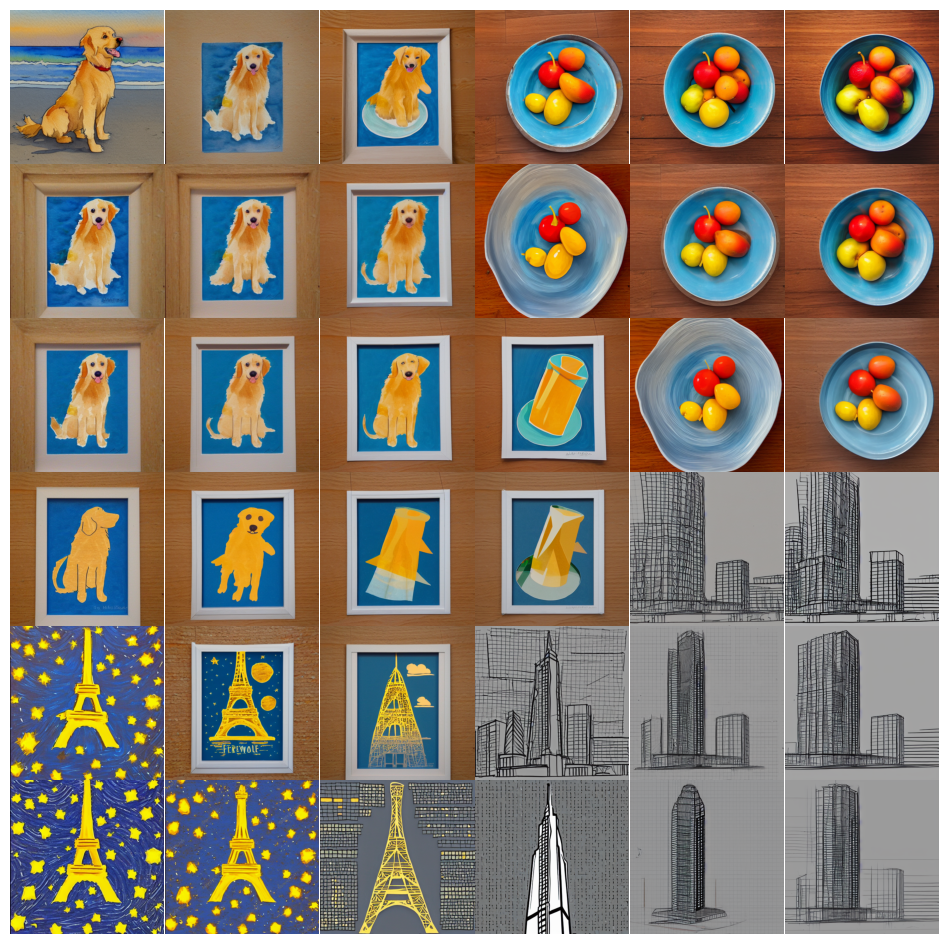

In [7]:
prompt_1 = "A captivating medieval castle surrounded by enchanting gardens and a flowing river"
prompt_2 = "An innovative and sustainable eco-village harmoniously integrated with its natural surroundings"
prompt_3 = "A sleek and futuristic high-speed train revolutionizing transportation between cities"
prompt_4 = "A bustling floating market filled with colorful boats and a vibrant array of goods"

interpolation_steps = 6
batch_size = 2
batches = (interpolation_steps**2) // batch_size

encoding_1 = tf.squeeze(model.encode_text(prompt_1))
encoding_2 = tf.squeeze(model.encode_text(prompt_2))
encoding_3 = tf.squeeze(model.encode_text(prompt_3))
encoding_4 = tf.squeeze(model.encode_text(prompt_4))

interpolated_encodings = tf.linspace(
    tf.linspace(encoding_1, encoding_2, interpolation_steps),
    tf.linspace(encoding_3, encoding_4, interpolation_steps),
    interpolation_steps,
)
interpolated_encodings = tf.reshape(
    interpolated_encodings, (interpolation_steps**2, 77, 768)
)
batched_encodings = tf.split(interpolated_encodings, batches)

images = []
for batch in range(batches):
    images.append(
        model.generate_image(
            batched_encodings[batch],
            batch_size=batch_size,
            diffusion_noise=noise,
        )
    )


def plot_grid(
    images,
    path,
    grid_size,
    scale=2,
):
    fig = plt.figure(figsize=(grid_size * scale, grid_size * scale))
    fig.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.margins(x=0, y=0)
    plt.axis("off")
    images = images.astype(int)
    for row in range(grid_size):
        for col in range(grid_size):
            index = row * grid_size + col
            plt.subplot(grid_size, grid_size, index + 1)
            plt.imshow(images[index].astype("uint8"))
            plt.axis("off")
            plt.margins(x=0, y=0)
    plt.savefig(
        fname=path,
        pad_inches=0,
        bbox_inches="tight",
        transparent=False,
        dpi=60,
    )


images = np.concatenate(images)
plot_grid(images, "4-way-interpolation.jpg", interpolation_steps)

50/50 [==============================] - 23s 460ms/step


<ipython-input-7-ec702fbe0ef7>:51: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(grid_size, grid_size, index + 1)


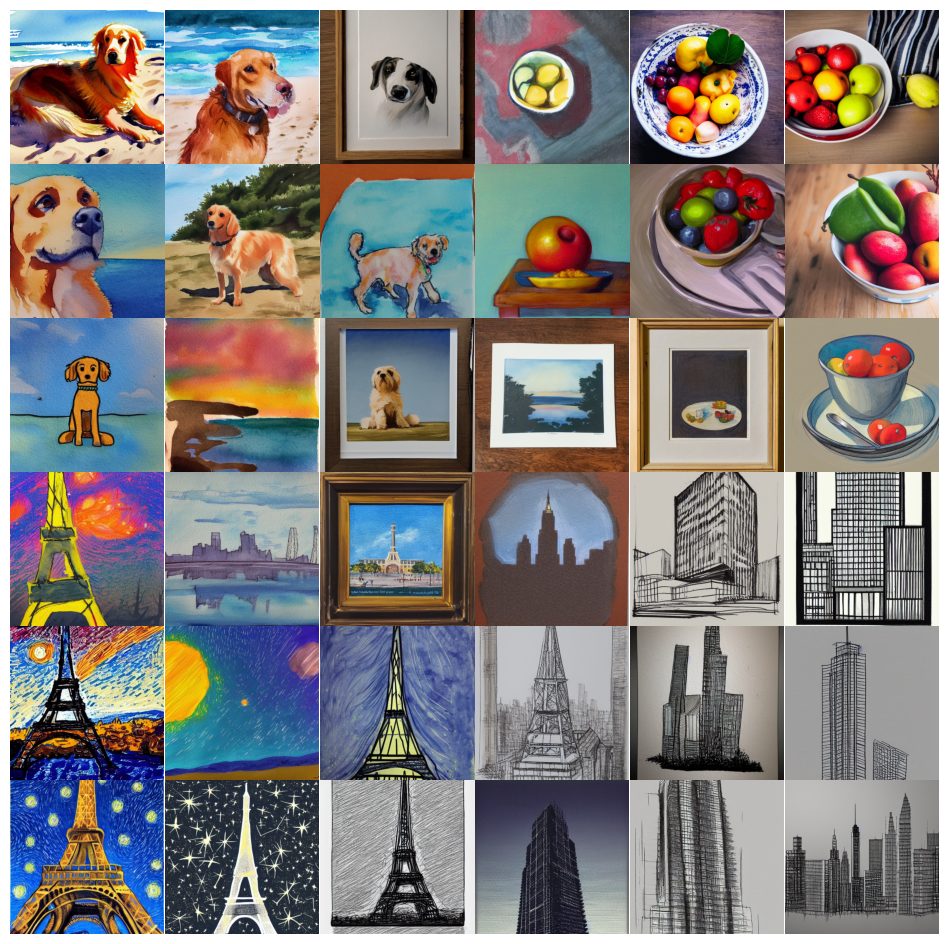

In [8]:
images = []
for batch in range(batches):
    images.append(model.generate_image(batched_encodings[batch], batch_size=batch_size))

images = np.concatenate(images)
plot_grid(images, "4-way-interpolation-varying-noise.jpg", interpolation_steps)

In [9]:
walk_steps = 150
batch_size = 2
batches = walk_steps // batch_size
step_size = 0.005

encoding = tf.squeeze(
    model.encode_text("The Eiffel Tower in the style of starry night")
)
# Note that (77, 768) is the shape of the text encoding.
delta = tf.ones_like(encoding) * step_size

walked_encodings = []
for step_index in range(walk_steps):
    walked_encodings.append(encoding)
    encoding += delta
walked_encodings = tf.stack(walked_encodings)
batched_encodings = tf.split(walked_encodings, batches)

images = []
for batch in range(batches):
    images += [
        Image.fromarray(img)
        for img in model.generate_image(
            batched_encodings[batch],
            batch_size=batch_size,
            num_steps=25,
            diffusion_noise=noise,
        )
    ]

export_as_gif("eiffel-tower-starry-night.gif", images, rubber_band=True)

25/25 [==============================] - 12s 468ms/step


In [11]:
prompt = "An oil paintings of cows in a field next to a windmill in Holland"
encoding = tf.squeeze(model.encode_text(prompt))
walk_steps = 150
batch_size = 3
batches = walk_steps // batch_size

walk_noise_x = tf.random.normal(noise.shape, dtype=tf.float64)
walk_noise_y = tf.random.normal(noise.shape, dtype=tf.float64)

walk_scale_x = tf.cos(tf.linspace(0, 2, walk_steps) * math.pi)
walk_scale_y = tf.sin(tf.linspace(0, 2, walk_steps) * math.pi)
noise_x = tf.tensordot(walk_scale_x, walk_noise_x, axes=0)
noise_y = tf.tensordot(walk_scale_y, walk_noise_y, axes=0)
noise = tf.add(noise_x, noise_y)
batched_noise = tf.split(noise, batches)

images = []
for batch in range(batches):
    images += [
        Image.fromarray(img)
        for img in model.generate_image(
            encoding,
            batch_size=batch_size,
            num_steps=25,
            diffusion_noise=batched_noise[batch],
        )
    ]

export_as_gif("cows.gif", images)

ResourceExhaustedError: ignored